## Quantum reservoir computing

In this notebook we show how to design the quantum circuits that will be used as quantum reservoirs. We apply this framework to analyse the LiH molecule. The study for the H2O molecule is equivalent.

## Noise models

### Amplitude damping

The amplitude-damping channel is a schematic model of the decay of an excited state of a (two-level) atom due to spontaneous emission of a photon. By detecting the emitted photon (“observing the environment”) we can perform a POVM that gives us information about the initial preparation of the atom. 

+ Unitary representation: We denote the atomic ground state by $|0>_A$ and the excited state of interest by $|1>_A$. The environment is the electromagnetic field, assumed initially to be in its vacuum state $|0>_E$. After we wait a while, there is a probability $p$ that the excited state has decayed to the ground state and a photon has been emitted, so that the environment
has made a transition from the state $|0>_E$ (no photon) to the state $|1>_E$ (one photon emitted). The evolution of the atom and environment quantum states is given by:


$$
|0>_A \otimes |0>_E \longrightarrow |0>_A \otimes |0>_E 
$$

$$
|1>_A \otimes |0>_E \longrightarrow \sqrt{1-p}|1>_A \otimes |0>_E + \sqrt{p}|0>_A \otimes |1>_E
$$

+ Kraus operators: By evaluating the partial trace over the environment in the basis $\{|0>_E, |1>_E\}$, we find the Kraus operators

$$
M_0 = 
\begin{pmatrix} 
    1 & 0 \\
    0 & \sqrt{1-p}
\end{pmatrix}
$$

$$
M_1 = 
\begin{pmatrix} 
0 & \sqrt{p} \\
0 & 0
\end{pmatrix}
$$

The operator $M_1$ induces a quantum jump, the decay from $|1>_A$ to $|0>_A$, and $M_0$ describes how the state changes if no jump occurs. The density matrix evolves as

$$
\rho \longrightarrow \epsilon(\rho) = M_0\rho M_0^T + M_1\rho M_1^T = 
\begin{pmatrix}
\rho_{00} + p\rho_{11} & \sqrt{1-p} \rho_{01} \\
\sqrt{1-p} \rho_{10} & (1-p)\rho_{11}
\end{pmatrix}
$$



### Depolarizing noise

The depolarizing channel is a model where a qubit suffers an error with probability $p$, and stays intact with probability $1-p$. Three types of error can occur, with equal probability:

+ 1. Bit-flip error: $|0> \longrightarrow |1>, |1> \longrightarrow |0>$, or equivalently $|\psi> \longrightarrow X |\psi>$
+ 2. Phase-flip error: $|0> \longrightarrow |0>, |1> \longrightarrow -|1>$, or equivalently $|\psi> \longrightarrow Z |\psi>$
+ 3. Both errors: $|0> \longrightarrow i|1>, |1> \longrightarrow -i|0>$, or equivalently $|\psi> \longrightarrow Y |\psi>$


If an error occurs, then $|\psi>$ evolves to an ensemble of the three states $X|\psi>$, $Y|\psi>$, $Z|\psi>$, all occurring with equal likelihood.

+ Unitary representation: A state $|\psi>_A$ evolves to

$$
|\psi>_A \longrightarrow \sqrt{1-p}|\psi>_A \otimes |0>_E + \sqrt{\frac{p}{3}} (X|\psi>_A\otimes |1>_E + Y|\psi>_A\otimes |2>_E + Z|\psi>_A\otimes |3>_E
$$

+ Kraus representation: By evaluating the partial trace over the 4-level environment, we obtain the Kraus operators

$$
M_0 = \sqrt{1-p} I, M_1= \sqrt{\frac{p}{3}}X, M_2= \sqrt{\frac{p}{3}}Y, M_3= \sqrt{\frac{p}{3}}Z
$$

The density matrix evolves like:

$$
\rho \longrightarrow (1-p)\rho + \frac{p}{3}(X\rho X + Y\rho Y + Z\rho Z)
$$

### Phase damping

In this case, qubit A does not make any transitions in the computational basis $\{|0>_A, |1>_A\}$. Instead, the environment scatters off of the qubit occasionally (with probability $p$), being kicked into the state $|1>_E$ if A is in the state $|0>_A$ and into the state $|2>_E$ if A is in the state $|1>_A$. Furthermore, also unlike the depolarizing channel, the channel picks out a preferred basis for qubit A; the basis $\{|0>_A, |1>_A\}$ is the only basis in which bit flips never occur.

+ Unitary representation: 

$$
|0>_A \longrightarrow \sqrt{1-p} |0>_A \otimes |0>_E + \sqrt{p} |0>_A \otimes |1>_E
$$
$$
|1>_A \longrightarrow \sqrt{1-p} |1>_A \otimes |0>_E + \sqrt{p} |1>_A \otimes |2>_E
$$

+ Kraus operators: evaluating the partial trace over qubit E, we find:

$$
M_0 = \sqrt{1-p} I, 
M_1 = \sqrt{p} 
\begin{pmatrix}
1 & 0 \\
0 & 0 \\
\end{pmatrix},
M_2 = \sqrt{p} 
\begin{pmatrix}
0 & 0 \\
0 & 1 \\
\end{pmatrix}
$$

and the density matrix evolves as:

$$
\rho \longrightarrow \epsilon(\rho) = (1 - \frac{1}{2}p)\rho + \frac{p}{2} Z\rho Z
$$
so an alternative description of the channel is that $Z$ is applied with probability $p/2$ and nothing happens with probability $(1 − p/2)$.

In [13]:
import numpy as np
from numpy.lib.scimath import sqrt as csqrt
from qiskit import QuantumCircuit,execute
from qiskit import BasicAer
from qiskit.compiler import transpile
from qiskit.quantum_info import Statevector
from scipy.stats import unitary_group

from qiskit.opflow import StateFn
from qiskit.opflow import Z,X,Y
from qiskit.quantum_info import Pauli
from qiskit.opflow import *
from qiskit.circuit.library import Diagonal
from qiskit.extensions import  UnitaryGate, CCXGate
from qiskit.providers.aer.noise import NoiseModel
import qiskit.providers.aer.noise as noise
from qiskit import IBMQ, Aer
from qiskit.test.mock import FakeProvider
from qiskit.test.mock import *
from qiskit.quantum_info import Statevector, state_fidelity

import random
from tqdm import tqdm

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
import matplotlib.pyplot as plt

import itertools

C:\Users\laiad\AppData\Local\Temp/ipykernel_16520/1052137374.py:18: DeprecationWarning: The module 'qiskit.test.mock' is deprecated since Qiskit Terra 0.21.0, and will be removed 3 months or more later. Instead, you should import the desired object directly 'qiskit.providers.fake_provider'.
  from qiskit.test.mock import FakeProvider


In [2]:
with open('../training_data/spectrums_LiH.npy', 'rb') as f:
            spectrums = np.load(f)
with open('../training_data/bond_lengths_LiH.npy', 'rb') as f:
            bond_lengths = np.load(f)
with open('../training_data/ground_states_LiH.npy', 'rb') as f:
            ground_states = np.load(f)

## Initialize the quantum circuit

The input quantum state of the quantum circuit is the ground state of the molecule. Therefore, we need to initialize the circuit with a state different than $|00..0>$. We use Qiskit to create the circuit to initialize the quantum circuit.

In [3]:
initial_state = ground_states[-1].round(6)
initial_state/=np.sqrt(np.sum(initial_state**2))

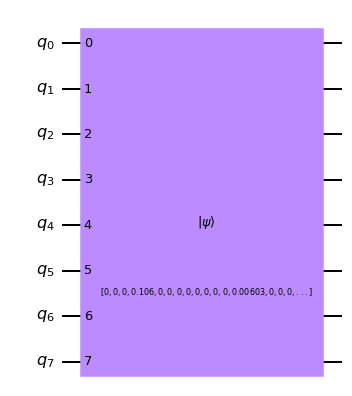

In [4]:
nqbits = 8
qc = QuantumCircuit(nqbits)
qc.initialize(initial_state, list(range(nqbits)))
qc.draw('mpl')

We check that the circuit in fact creates the initial state that we want. We measure the final state and compared to the ground state.

In [5]:
backend = BasicAer.get_backend('statevector_simulator')
job = backend.run(transpile(qc, backend))
qc_state = job.result().get_statevector(qc)
print('Proportion of equal values', np.sum(np.isclose(qc_state, initial_state))/len(qc_state))

Statevector(qc_state).to_dict()

Proportion of equal values 1.0


{'00000011': (0.10606201687351394+2.36876490644633e-15j),
 '00001100': (0.006030000959318953+1.4422599399488423e-16j),
 '00010010': (-0.23841403792953172-5.860763263587643e-15j),
 '00100001': (0.23841403792953172+5.8538243696837355e-15j),
 '00110000': (0.45896907301785483+1.1568870861289327e-14j),
 '01000010': (-0.06954201106350937-1.7767905202692447e-15j),
 '01100000': (0.14577802319197422+3.589576552665008e-15j),
 '10000001': (0.06954201106350906+1.3728167908011457e-15j),
 '10010000': (-0.14577802319197372-3.456436525883788e-15j),
 '11000000': (-0.782435124478398-1.8922363675955012e-14j)}

Now that we have checked that the circuit reproduced the initial state, we create the actual quantum circuit that we use as a reservoir.

## Create the quantum circuit

Now we define the gates applied to the quantum circuit. In this case, we will sample the gates from the set 

$$
G_3 = \{CNOT, H, T\}
$$

where CNOT is the controlled-NOT gate, H stands for Hadamard, and T is the $\pi/4$-phase gate. We generate the gates randomly and select the qubit where it applies also randomly.

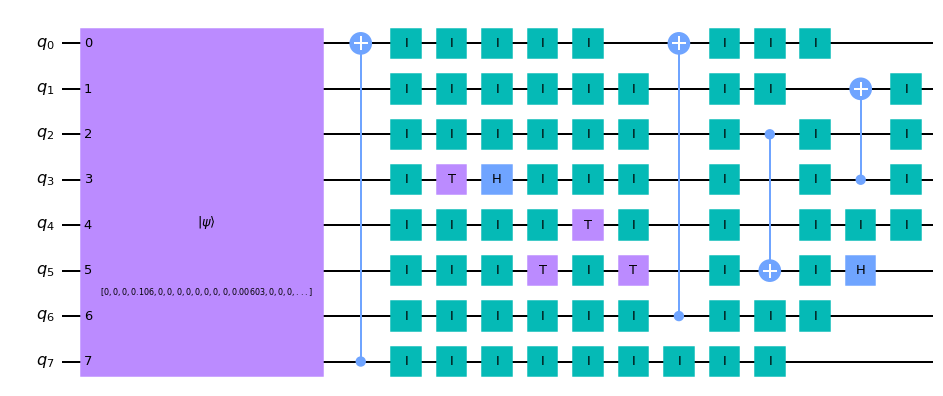

In [6]:
num_gates=10
nqbits = 8
gates_set = ['CNOT', 'T', 'H']
gate_idx = list(range(len(gates_set)))
qubit_idx = list(range(nqbits))

# Initialize quantum circuit
qc = QuantumCircuit(nqbits)
qc.initialize(initial_state, list(range(nqbits)))


# Apply random gates to random qubits
for i in range(num_gates):
    # Select random gate
    # Select random gate
    idx = random.sample(gate_idx,1)[0] 
    gate = gates_set[idx]
    if gate=='CNOT': # For 2-qubit gates
        # Select qubit 1 and 2 (different qubits)
        qbit1 = random.sample(qubit_idx,1)[0]
        qubit_idx2 = qubit_idx.copy()
        qubit_idx2.remove(qbit1)
        qbit2 = random.sample(qubit_idx2,1)[0]
        qubit_idx2.remove(qbit2)
        # Apply gate to qubits
        qc.cx(qbit1, qbit2) 
        # Apply identity gates to other gates
        for qbit in qubit_idx2:
            qc.id(qbit)
    else: # For 1-qubit gates
        # Select qubit
        qbit = random.sample(qubit_idx,1)[0]
        qubit_idx2 = qubit_idx.copy()
        qubit_idx2.remove(qbit)
        if gate=='X':# Apply gate
            qc.x(qbit) 
        if gate=='S':
            qc.s(qbit) 
        if gate=='H':
            qc.h(qbit) 
        if gate=='T':
            qc.t(qbit) 
        # Apply identity gates to other gates
        for qbit in qubit_idx2:
            qc.id(qbit)
qc.draw('mpl')

## Define observables to measure

We measure 
$$
<X_0>, <Z_0>, \cdots, <X_7>, <Z_7>
$$

In [7]:
observables = []
name_gate=''
for i in range(nqbits):
    name_gate+= 'I' 
for i in range(nqbits):
    # X
    op_nameX = name_gate[:i] + 'X' + name_gate[(i+1):]
    obs = PauliOp(Pauli(op_nameX))
    observables.append(obs)
    # Z
    op_nameZ = name_gate[:i] + 'Z' + name_gate[(i+1):]
    obs = PauliOp(Pauli(op_nameZ))
    observables.append(obs)

## Noise model

We generate the noise model for the circuit. In this case we choose the depolarizing channel with probability $p=0.001$.

In [8]:
# Error probabilities
prob_1 = 0.001  # 1-qubit gate
prob_2 = 0.001   # 2-qubit gate

# Depolarizing quantum errors
error_1 = noise.depolarizing_error(prob_1, 1)
error_2 = noise.depolarizing_error(prob_2, 2)

# Add errors to noise model
noise_model = noise.NoiseModel()
noise_model.add_all_qubit_quantum_error(error_1, ['x','h','ry','rz', 'id'])
noise_model.add_all_qubit_quantum_error(error_2, ['cx'])

# Get basis gates from noise model
basis_gates = noise_model.basis_gates

We now call the backen to calculate the expected values of these operators.

In [9]:
results = []
# Perform a noise simulation
qc_state = execute(qc, Aer.get_backend('statevector_simulator'),
                 basis_gates=basis_gates,
                 noise_model=noise_model).result().get_statevector(qc)

for obs in observables:
    obs_mat = obs.to_spmatrix()
    expect = np.inner(np.conjugate(qc_state), obs_mat.dot(qc_state)).real
    results.append(expect)

In [10]:
print(np.array(results).round(4))

[-0.     -0.2766 -0.0541 -0.2766  0.4224  0.      0.      0.4225 -0.
 -0.      0.      0.9999 -0.      0.      0.      0.7691]


# All together

We define a function wich takes as input the ground state of the system and the parameters of the circuit (number of gates, gate set, observables, noise model) and outputs the expected value of the observables.

In [14]:
class QuantumCircQiskit:
    def __init__(self, gates_name, num_gates=50,nqbits=8,observables_type = 'fidelity',
                 err_type='depolarizing', err_p1=0.001, err_p2=0.01, err_idle=0.00001):
        
        self.num_gates = num_gates
        self.gates_name = gates_name
        self.observables_type = observables_type
        self.gates_set = []
        self.qubits_set = []
        self.nqbits=nqbits
        self.coupling_map=None
        self.err_type = err_type
        if err_type is not None:
            noise_model, basis_gates = self.get_noise_model(err_type=err_type, p1=err_p1, p2=err_p2, p_idle=err_idle)
        else:
            noise_model, basis_gates = None, None
            
        self.noise_model = noise_model
        self.basis_gates = basis_gates
        if self.gates_name=='G1':
            gates = ['CNOT', 'H', 'X']
        if self.gates_name=='G2':
            gates = ['CNOT', 'H', 'S']
        if self.gates_name=='G3':
            gates = ['CNOT', 'H', 'T']  
        if self.gates_name=='HT':
            gates = ['H', 'T']  
        if self.gates_name=='Toffoli':
            gates = ['CCX'] 


        qubit_idx = list(range(self.nqbits))
        # Store gates
        if self.gates_name in ['G1', 'G2', 'G3', 'Toffoli']:
            for i in range(self.num_gates):
                # Select random gate
                gate = random.sample(gates,1)[0] 
                self.gates_set.append(gate)
                if gate=='CNOT':
                    # Select qubit 1 and 2 (different qubits)
                    qbit1 = random.sample(qubit_idx,1)[0]
                    qubit_idx2 = qubit_idx.copy()
                    qubit_idx2.remove(qbit1)
                    qbit2 = random.sample(qubit_idx2,1)[0]
                    self.qubits_set.append([qbit1, qbit2])
                elif gate=='CCX':
                    # Select qubit 1, 2 and 3 (different qubits)
                    qbit1 = random.sample(qubit_idx,1)[0]
                    qubit_idx2 = qubit_idx.copy()
                    qubit_idx2.remove(qbit1)
                    qbit2 = random.sample(qubit_idx2,1)[0]
                    qubit_idx3 = qubit_idx2.copy()
                    qubit_idx3.remove(qbit2)
                    qbit3 = random.sample(qubit_idx3,1)[0]
                    self.qubits_set.append([qbit1, qbit2, qbit3])
                else:
                    # Select qubit
                    qbit = random.sample(qubit_idx,1)[0]
                    self.qubits_set.append([qbit])
        elif self.gates_name=='D2':
            qubit_idx = list(range(self.nqbits))
            self.qubits_set = list(itertools.combinations(qubit_idx, 2))
            self.phis = np.random.uniform(0, 2*np.pi, size=(len(self.qubits_set), 2**2))
        elif self.gates_name=='D3':
            qubit_idx = list(range(self.nqbits))
            self.qubits_set = list(itertools.combinations(qubit_idx, 3))
            self.phis = np.random.uniform(0, 2*np.pi, size=(len(self.qubits_set), 2**3))
        elif self.gates_name=='Dn':
            self.phis = np.random.uniform(0, 2*np.pi, size=(2**self.nqbits))
        elif self.gates_name=='MG':
            for i in range(self.num_gates):
                G = self.matchgate()
                self.gates_set.append(G)
                qbit1 = random.sample(qubit_idx,1)[0]
                qubit_idx2 = qubit_idx.copy()
                qubit_idx2.remove(qbit1)
                qbit2 = random.sample(qubit_idx2,1)[0]
                self.qubits_set.append([qbit1, qbit2])

                
    def initialization(self, initial_state):
        # 1. INITIALIZATION
        # Define initial state
        initial_state = initial_state.round(6)
        initial_state/=np.sqrt(np.sum(initial_state**2))

        # Define qiskit circuit to initialize quantum state
        self.nqbits = int(np.log2(initial_state.shape[0]))
        qc_initial = QuantumCircuit(self.nqbits)
        qc_initial.initialize(initial_state, list(range(self.nqbits)))
        
        aer_sim = Aer.get_backend('unitary_simulator')
        job = aer_sim.run(transpile(qc_initial, aer_sim))
        U = job.result().get_unitary()
        U = UnitaryGate(U, label='unitary')

        return U

    def apply_G_gates(self, qc):
        # Apply random gates to random qubits
        for i in range(self.num_gates):
            # Select random gate
            # Select random gate
            gate = self.gates_set[i]
            if gate=='CNOT': # For 2-qubit gates
                # Select qubit 1 and 2 (different qubits)
                qbit1, qbit2 = self.qubits_set[i]
                # Apply gate to qubits
                qc.cx(qbit1, qbit2) 
                # Appply identity operator to all idle qubits if we use an ide noise model
                if self.err_type=='depolarizing_idle' or self.err_type=='amplitude_damping_idle' or self.err_type=='phase_damping_idle':
                    qubit_idx = list(range(self.nqbits))
                    qubit_idx.remove(qbit1)
                    qubit_idx.remove(qbit2)
                    # Apply identity gates to other gates
                    for qbit in qubit_idx:
                        qc.id(qbit)
            if gate=='CCX':
                # Select qubit 1, 2 and 3 (different qubits)
                qbit1, qbit2, qbit3 = self.qubits_set[i]
                # Apply gate to qubits
                qc.ccx(qbit1, qbit2, qbit3) 
                if self.err_type=='depolarizing_idle' or self.err_type=='amplitude_damping_idle' or self.err_type=='phase_damping_idle':
                    qubit_idx = list(range(self.nqbits))
                    qubit_idx.remove(qbit1)
                    qubit_idx.remove(qbit2)
                    qubit_idx.remove(qbit3)
                    # Apply identity gates to other gates
                    for qbit in qubit_idx:
                        qc.id(qbit)
            else: # For 1-qubit gates
                # Select qubit
                qbit = self.qubits_set[i][0]
                if gate=='X':# Apply gate
                    qc.x(qbit) 
                if gate=='S':
                    qc.s(qbit) 
                if gate=='H':
                    qc.h(qbit) 
                if gate=='T':
                    qc.t(qbit) 
                # Appply identity operator to all idle qubits if we use an ide noise model
                if self.err_type=='depolarizing_idle' or self.err_type=='amplitude_damping_idle' or self.err_type=='phase_damping_idle':
                    qubit_idx = list(range(self.nqbits))
                    qubit_idx.remove(qbit)
                    # Apply identity gates to other gates
                    for qbit in qubit_idx:
                        qc.id(qbit)
                
    
    def apply_matchgates(self, qc):
        for i in range(self.num_gates):
            gate = self.gates_set[i]
            qbit1, qbit2 = self.qubits_set[i]
            qc.unitary(gate, [qbit1, qbit2], label='MG')
            # Appply identity operator to all idle qubits if we use an ide noise model
            if self.err_type=='depolarizing_idle' or self.err_type=='amplitude_damping_idle' or self.err_type=='phase_damping_idle':
                qubit_idx = list(range(self.nqbits))
                qubit_idx.remove(qbit1)
                qubit_idx.remove(qbit2)
                # Apply identity gates to other gates
                for qbit in qubit_idx:
                    qc.id(qbit)
            
    def matchgate(self):
        A = unitary_group.rvs(2)
        B = unitary_group.rvs(2)
        detA = np.linalg.det(A)
        detB = np.linalg.det(B)
        B = B/np.sqrt(detB)*np.sqrt(detA)
        G = np.array([[A[0,0],0,0,A[0,1]],[0,B[0,0], B[0,1],0],
                      [0,B[1,0],B[1,1],0],[A[1,0],0,0,A[1,1]]])
        return G
    
    def apply_Dn(self, qc):
        # Apply Dn gate
        diagonals = np.exp(1j*self.phis)
        qc += Diagonal(diagonals)
        
    def apply_D2(self, qc):
        i=0
        for pair in self.qubits_set:
            # Apply D2 gate
            diagonals = np.diag(np.exp(1j*self.phis[i]))
            D2 = UnitaryGate(diagonals)
            qc.append(D2, [pair[0], pair[1]])
            i+=1
            # Appply identity operator to all idle qubits if we use an ide noise model
            if self.err_type=='depolarizing_idle' or self.err_type=='amplitude_damping_idle' or self.err_type=='phase_damping_idle':
                qubit_idx = list(range(self.nqbits))
                qubit_idx.remove(pair[0])
                qubit_idx.remove(pair[1])
                # Apply identity gates to other gates
                for qbit in qubit_idx:
                    qc.id(qbit)
            
    def apply_D3(self, qc):
        i=0
        for pair in self.qubits_set:
            # Apply D3 gate
            diagonals = np.diag(np.exp(1j*self.phis[i]))
            D3 = UnitaryGate(diagonals)
            qc.append(D3, [pair[0], pair[1], pair[2]])
            i+=1
            # Appply identity operator to all idle qubits if we use an ide noise model
            if self.err_type=='depolarizing_idle' or self.err_type=='amplitude_damping_idle' or err_type=='phase_damping_idle':
                qubit_idx = list(range(self.nqbits))
                qubit_idx.remove(pair[0])
                qubit_idx.remove(pair[1])
                qubit_idx.remove(pair[2])
                # Apply identity gates to other gates
                for qbit in qubit_idx:
                    qc.id(qbit)
                    
    def get_noise_model(self, err_type='depolarizing', p1=0.001, p2=0.01, p_idle=0.0001):
        # Error probabilities: p1=1-qubit gate, p2=2-qubit gate
        if err_type=='depolarizing' or err_type=='depolarizing_idle':
            # Depolarizing quantum errors
            error_1 = noise.depolarizing_error(p1, 1)
            error_2 = noise.depolarizing_error(p2, 2)
            error_idle = noise.depolarizing_error(p_idle, 1)
        elif err_type=='phase_damping' or err_type=='phase_damping_idle':
            # Depolarizing quantum errors
            error_1 = noise.phase_damping_error(p1, 1)
            error_2 = noise.phase_damping_error(p2, 2)
            error_2 = error_1.tensor(error_2)
            error_idle = noise.phase_damping_error(p_idle, 1)
        elif err_type=='amplitude_damping' or err_type=='amplitude_damping_idle':
            # Construct the error
            error_1 = noise.amplitude_damping_error(p1)
            error_2 = noise.amplitude_damping_error(p2)
            error_2 = error_1.tensor(error_2)
            error_idle = noise.amplitude_damping_error(p_idle, 1)
        elif err_type=='fake':
            provider = FakeProvider()
            names = [ b.name() for b in provider.backends() if b.configuration().n_qubits >= self.nqbits]
            if len(names)==0:
                raise ValueError('Error type not supported')
            fake = provider.get_backend(names[7])
            # Get coupling map from backend
            coupling_map = fake.configuration().coupling_map
            cmap = [[self.nqbits-1,1]]
            for i,j in coupling_map:
                if i<nqbits and j<nqbits:
                    cmap.append([i,j]) 
            self.coupling_map = cmap
            noise_model = NoiseModel.from_backend(fake)
            basis_gates = noise_model.basis_gates
            return noise_model, basis_gates
        else:
            raise ValueError('Error type not supported', err_type)
        # Add errors to noise model
        noise_model = noise.NoiseModel()
        
        noise_model.add_all_qubit_quantum_error(error_1, ['x','h','ry','rz','u1', 'u2', 'u3'])
        noise_model.add_all_qubit_quantum_error(error_2, ['cx'])
        noise_model.add_basis_gates('unitary')
        if err_type=='depolarizing_idle' or err_type=='amplitude_damping_idle' or err_type=='phase_damping_idle':
            noise_model.add_all_qubit_quantum_error(error_idle, ['id'])

        # Get basis gates from noise model
        basis_gates = noise_model.basis_gates
        return noise_model, basis_gates
        
    def get_observables(self):
        observables = []
        name_gate=''
        for i in range(self.nqbits):
            name_gate+= 'I' 
        for i in range(self.nqbits):
            # X
            op_nameX = name_gate[:i] + 'X' + name_gate[(i+1):]
            obs = PauliOp(Pauli(op_nameX))
            observables.append(obs)
            # Y
            op_nameY = name_gate[:i] + 'Y' + name_gate[(i+1):]
            obs = PauliOp(Pauli(op_nameY))
            observables.append(obs)
            # Z
            op_nameZ = name_gate[:i] + 'Z' + name_gate[(i+1):]
            obs = PauliOp(Pauli(op_nameZ))
            observables.append(obs)
        return observables

    def run_circuit(self, initial_state):

        # 1. INITIALIZATION
        U = self.initialization(initial_state)
        
        qc =  QuantumCircuit(self.nqbits)
        qc.append(U, list(range(self.nqbits)))
        # 2. DEFINE RANDOM CIRCUIT
        if self.gates_name in ['G1', 'G2', 'G3', 'Toffoli']:
            self.apply_G_gates(qc)
        elif self.gates_name=='D2':
            self.apply_D2(qc)
        elif self.gates_name=='D3':
            self.apply_D3(qc)
        elif self.gates_name=='Dn':
            self.apply_Dn(qc)
        elif self.gates_name=='MG':
            self.apply_matchgates(qc)
        else:
            print('Unknown gate')

        # 3. DEFINE OBSERVABLES
        # Define observables to measure
        if self.observables_type=='single' or self.observables_type=='all':
            observables = self.get_observables()

        # 4. RUN CIRCUIT
        results = []
        results_noise = []
        
        backend = Aer.get_backend('statevector_simulator')
        if self.noise_model is not None:
            # Perform a noisy simulation
            if self.err_type=='depolarizing_idle' or self.err_type=='amplitude_damping_idle' or self.err_type=='phase_damping_idle':
                optimization_level=0
            else:
                optimization_level=1
            qc_state = execute(qc, backend,
                             basis_gates=self.basis_gates,
                             coupling_map = self.coupling_map,
                             noise_model=self.noise_model, optimization_level=optimization_level).result().get_statevector(qc)
            
        else:
            job = backend.run(transpile(qc, backend))
            qc_state = job.result().get_statevector(qc)
        
        if self.observables_type=='fidelity':
            backend = Aer.get_backend('statevector_simulator')
            job = backend.run(transpile(qc, backend))
            qc_state_noiseless = job.result().get_statevector(qc)
            state_noise = Statevector(qc_state)
            state_noiseless = Statevector(qc_state_noiseless)
            fidelity = state_fidelity(state_noise,state_noiseless)
            return np.array(state_noise), np.array(state_noiseless), fidelity
        
        if self.observables_type=='all':
            backend = Aer.get_backend('statevector_simulator')
            job = backend.run(transpile(qc, backend))
            qc_state_noiseless = job.result().get_statevector(qc)
            state_noise = Statevector(qc_state)
            state_noiseless = Statevector(qc_state_noiseless)
            fidelity = state_fidelity(state_noise,state_noiseless)
            for obs in observables:
                obs_mat = obs.to_spmatrix()
                expect = np.inner(np.conjugate(state_noise), obs_mat.dot(state_noise)).real
                results_noise.append(expect)
                expect = np.inner(np.conjugate(state_noiseless), obs_mat.dot(state_noiseless)).real
                results.append(expect)
            return np.array(state_noise), np.array(state_noiseless), fidelity, np.array(results), np.array(results_noise)
        
        if self.observables_type=='single':
            for obs in observables:
                obs_mat = obs.to_spmatrix()
                expect = np.inner(np.conjugate(qc_state), obs_mat.dot(qc_state)).real
                results.append(expect)

            return np.array(results)
        else:
            return qc_state

In [15]:
# Run circuit for all values of ground states:
obs_res = []
num_states =ground_states.shape[0]
qc = QuantumCircQiskit('G3', num_gates=135,nqbits=8,observables_type = 'all',
                      err_type='amplitude_damping', err_p1=0.0005, err_p2=0.0005)

fidelity_list, obs_res, obs_noise = [],[],[]
for i in tqdm(range(num_states)):
    _, _, fidelity, res, res_noise = qc.run_circuit(ground_states[i])
    fidelity_list.append(fidelity)
    obs_res.append(res)
    obs_noise.append(res_noise)
obs_res = np.array(obs_res) 
obs_noise = np.array(obs_noise) 

100%|██████████| 300/300 [32:17<00:00,  6.46s/it]


## Generate target

The target of the model is

$$
y(t) = (\Delta E_1(r), \Delta E_2(r))
$$

We normalize $y(r)$ so that it lies between 0 and 1 for all the data.

In [16]:
y = np.zeros((num_states, 2))
y[:,0] = spectrums[:,1] - spectrums[:,0]
y[:,1] = spectrums[:,2] - spectrums[:,0]

## Train and test data

In [17]:
X_train, X_test, y_train, y_test, bond_lengths_train, bond_lengths_test = train_test_split( 
    obs_res, y, bond_lengths, test_size=0.33, random_state=42)

In [18]:
size = obs_res.shape[0]
idx1 = int(0.2*size)
idx2 = int(0.5*size)
train_idx=list(range(idx1)) + list(range(idx2, size))
X_train, y_train, bond_lengths_train = obs_res[train_idx], y[train_idx], bond_lengths[train_idx]
X_test, y_test, bond_lengths_test = obs_res[idx1:idx2], y[idx1:idx2], bond_lengths[idx1:idx2]

## Scale y

In [19]:
scaler = MinMaxScaler()
y_train_scaled = scaler.fit_transform(y_train)
y_test_scaled = scaler.transform(y_test)

## Train Ridge regression

In [20]:
lm = Ridge(alpha=1e-8)
lm.fit(X_train, y_train_scaled)

Ridge(alpha=1e-08)

## Test model

Mean Square Error  4.227818879830985e-06


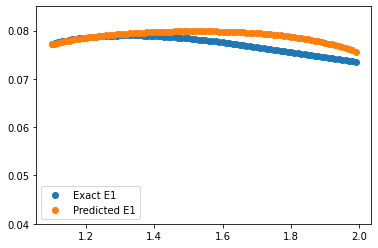

In [23]:
y_hat = lm.predict(X_test)
y_hat = scaler.inverse_transform(y_hat)

idx_rm = (y_hat[:,0]>0.08) | (y_hat[:,0]<0.0)
mse = np.mean(np.square(y_hat[~idx_rm,0] - y_test[~idx_rm,0]))
#mse = np.mean(np.square(y_hat[:,0] - y_test[:,0]))
print('Mean Square Error ', mse)

plt.scatter(bond_lengths_test,y_test[:,0], label='Exact E1', marker='o')
plt.scatter(bond_lengths_test, y_hat[:,0], label='Predicted E1', marker='o')
plt.ylim(0.04,0.085)
plt.legend()
plt.show()

Now we just have to repeat this experiment 100 times for all the families of gates. The script `runQC` can be used to run the simulations. To run them, just type:

`python runQC.py num_gates gates_set observable_type error_type p1 p2`

where 

+ `num_gates` is the number of gates (in this work we have used 20, 50, 100, 150, 200)
+ `gates_set` is the name of the gate set, from the list [G1, G2, G3, MG, D2, D3, Dn]
+ `observable_type` is either *single* which only returns the expected values, *fidelity* which returns the state fidelities or *all*, which returns the expected values, fidelitites and final states
+ `error_type` must be *amplitude_damping*, *depolarizing*, *phase_damping* or *fake*, which corresponds to a fake provider
+ `p1` is the error probability of qubit 1
+ `p2` is the error probability of qubit 2